<a href="https://colab.research.google.com/github/datasocode/Analyse-statistique-et-classification/blob/main/Analyse_Statistique_et_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Objectif du projet : Construire un algorithme capable de différencier automatiquement les vrais des faux billets à partir de leurs caractéristiques géométriques.

# 1. Exploration des données (EDA)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix,roc_auc_score,roc_curve

In [ ]:
from ydata_profiling import ProfileReport

df = pd.read_csv('billets.csv', sep=';')
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df['is_genuine'] = df['is_genuine'].astype(str).map({'True':1,'False':0})
df.head(2)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09


In [ ]:
# L'ajout d'une constante est nécessaire pour une interprétation correcte des coefficients de régression

df = sm.add_constant(df,has_constant = "add")
df.head(2)

,const,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,1,171.46,103.36,103.66,3.77,2.99,113.09


In [ ]:
df.isnull().sum()

const            0
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

# 2. Régression linéaire pour compléter les données manquantes.

* Analyse des variables significatives : Influence statistiquement significative des variables "is_genuine" et "margin_up" sur "margin_low".

### Analyser la relation entre les variables à l'aide de la régression linéaire

In [ ]:
import statsmodels.formula.api as smf

reg_simple = smf.ols('margin_low~is_genuine', data=df).fit()
print(reg_simple.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     2316.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):          1.36e-303
Time:                        17:10:53   Log-Likelihood:                -781.24
No. Observations:                1463   AIC:                             1566.
Df Residuals:                    1461   BIC:                             1577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.2159      0.019    280.120      0.0

In [ ]:
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length',
                    data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Sun, 30 Jul 2023   Prob (F-statistic):          4.75e-299
Time:                        17:10:53   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.8668      8.316      0.345   

In [ ]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=df).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):          1.24e-304
Time:                        17:10:53   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9263      0.198     30.003      0.0

### Imputation des valeurs manquantes avec LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

df_msl = df.dropna()

ind_cols = ['is_genuine', 'margin_up']

X = df_msl[ind_cols]
y = df_msl['margin_low']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41)

regression = LinearRegression()
regression.fit(X_train, y_train)

y_pred = regression.predict(X_test)

df_ms_only = df[df.isna().any(axis=1)].copy()

predicted_values = regression.predict(df_ms_only[ind_cols])
df_ms_only['margin_low'] = predicted_values

In [ ]:
df2 = pd.concat([df_msl, df_ms_only], axis=0)
df2.head(2)

,const,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1.0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1.0,1,171.46,103.36,103.66,3.77,2.99,113.09


In [ ]:
r2 = r2_score(y_test, y_pred)
print("R2 score:", round(r2, 3))

R2 score: 0.584


### La validation croisée (cross-validation)

* La validation croisée est utilisée pour évaluer la performance d'un modèle en présence de valeurs manquantes. Elle permet d'obtenir une estimation plus fiable en utilisant différentes combinaisons d'entraînement et de tests sur les données.

In [ ]:
from sklearn.model_selection import cross_val_score

# Validation croisée avec 5 folds
scores = cross_val_score(regression, X, y, cv=5, scoring='r2')

# Affichage des scores de validation croisée

print("Scores de validation croisée:", scores)
print("Score moyen:", round(scores.mean(), 3))

Scores de validation croisée: [-0.00608849 -0.04128587  0.02970353  0.49926568  0.01231634]
Score moyen: 0.099


### Imputer les valeurs manquantes avec KNNImputer

In [ ]:
from sklearn.impute import KNNImputer

ind_cols = ['is_genuine', 'margin_up']
dep_col = ['margin_low']

imputer = KNNImputer(n_neighbors=3)

df_no_missing = df.dropna()

X = df_no_missing[ind_cols]
y = df_no_missing[dep_col]

imputer.fit(X, y)

df_missing = df[df.isna().any(axis=1)].copy()

# Utiliser l'imputeur pour remplacer les valeurs manquantes dans la colonne 'margin_low'
df_missing['margin_low'] = imputer.transform(df_missing[ind_cols])

df_interpolated = pd.concat([df_no_missing, df_missing], axis=0)

y_test = df_no_missing['margin_low']
y_pred = df_interpolated.loc[df_no_missing.index, 'margin_low']

r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

R2 score: 1.0


In [ ]:
x_imputed = df_interpolated[ind_cols]
y_imputed = df_interpolated['margin_low']

knn_scores = cross_val_score(regression, x_imputed, y_imputed, cv=5, scoring='r2')

# Affichage des scores de validation croisée pour l'imputation KNN

print("Scores de validation croisée - Imputation KNN:", knn_scores)
print("Score moyen - Imputation KNN:", round(knn_scores.mean(), 3))

Scores de validation croisée - Imputation KNN: [-0.20240569 -0.14617405 -0.15483489  0.42605201  0.20499342]
Score moyen - Imputation KNN: 0.026


* Le score R2 du modèle de régression linéaire est de 0,584, ce qui signifie qu'il peut expliquer environ 58,4 % de la variabilité de la variable "margin_low".
* Le score R2 du modèle utilisant KNNImputer est de 1,0, suggérant une explication parfaite de la variabilité de "margin_low". Cependant, ce résultat élevé peut indiquer un surajustement(overfitting) potentiel.

* En utilisant la validation croisée, le score moyen de validation croisée du modèle de régression linéaire est de 0,0988, tandis que le score moyen de validation croisée du modèle KNN est de 0,0255. Par conséquent, le modèle de régression linéaire semble avoir de meilleures performances.

*  Cela signifie que le modèle de régression linéaire est capable de fournir des estimations plus précises et plus proches des vraies valeurs manquantes lorsqu'il est confronté à de nouvelles données.

### Hypothèse de la normalité des résidus

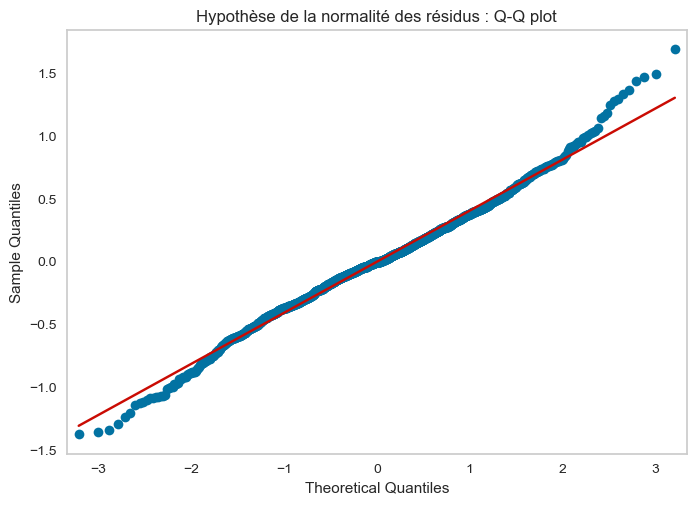

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

X = df2[['is_genuine', 'margin_up']].copy()
y = df2['margin_low']

regression = LinearRegression()
regression.fit(X, y)
predicted_values = regression.predict(X)
residuals = y - predicted_values

sm.qqplot(residuals, line='s')
plt.title("Hypothèse de la normalité des résidus : Q-Q plot")
plt.grid(False)

plt.show()

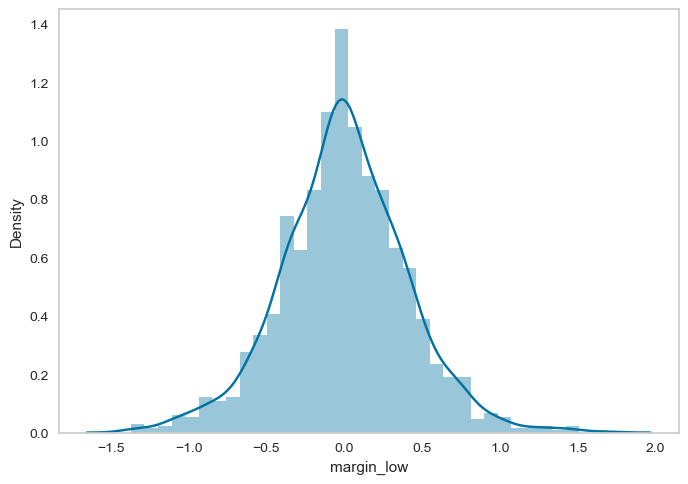

In [ ]:
sns.distplot(residuals)
plt.grid(False)

plt.show()

In [ ]:
from scipy.stats import shapiro

shapiro_test_statistic, shapiro_p_value = shapiro(residuals)
print('Shapiro-Wilk test statistic:', shapiro_test_statistic)
print('p-value for Shapiro-Wilk test:', shapiro_p_value)

Shapiro-Wilk test statistic: 0.99214768409729
p-value for Shapiro-Wilk test: 3.5976987078356615e-07


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['is_genuine','margin_up']]

X = sm.add_constant(X)

model = sm.OLS(df['margin_low'], X)
results = model.fit()

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

# En général, lorsque le VIF est supérieur à 5 ou 10, cela indique une colinéarité élevée,
# ce qui signifie que la variable est fortement corrélée avec les autres variables explicatives.
# Dans mon cas, les variables ont des VIF relativement faibles, ce qui suggère une faible colinéarité.
# Cela est généralement considéré comme souhaitable pour une régression linéaire.

     Variable         VIF
0       const  333.461762
1  is_genuine    1.581162
2   margin_up    1.581162


### Régression linéaire multiple pour prédire la variable 'is_genuine' avec les variables 'diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low' et 'length'.

In [ ]:
reg_multi = smf.ols('is_genuine~diagonal+height_left+height_right+margin_up+margin_low+length',
                    data=df2).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             is_genuine   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     1349.
Date:                Sun, 30 Jul 2023   Prob (F-statistic):               0.00
Time:                        17:10:53   Log-Likelihood:                 394.50
No. Observations:                1500   AIC:                            -775.0
Df Residuals:                    1493   BIC:                            -737.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -12.2588      3.710     -3.304   

# 3. Algorithme de Classification Supervisé

## Régression Logistique - Analyse de la classification binaire

In [ ]:
from sklearn.linear_model import LogisticRegression

# Séparation X (features) et y (is_genuine)

X = df2[['diagonal','height_left', 'height_right', 'margin_up','margin_low','length']].copy()
y = df2.is_genuine

## Séparation train data et test data avec la méthod sklearn : train_test_split


In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify = y, test_size=0.3,random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1050, 6) (450, 6) (1050,) (450,)


In [ ]:
best_params = {'C': 10, 'solver': 'liblinear'}
model_lr = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
model_lr.fit(X_train, y_train)

LogisticRegression(C=10, solver='liblinear')

In [ ]:
y_pred_lr = model_lr.predict(X_test)

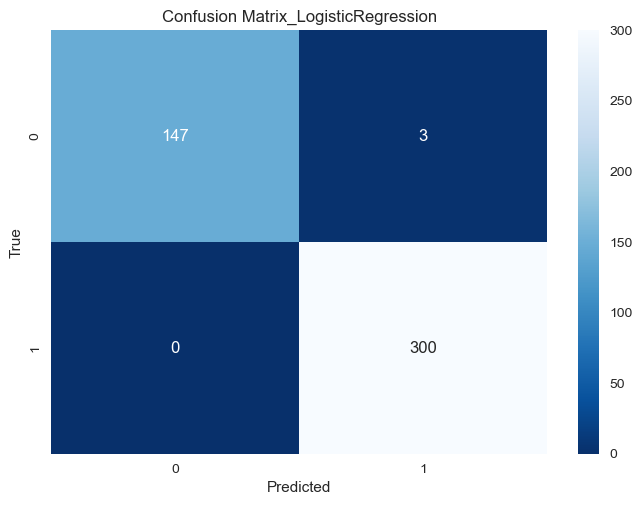

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

plt.title('Confusion Matrix_LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('Confusion Matrix_logisticregression.png')
plt.show()

In [ ]:
from sklearn import metrics

# Calculer le score R2

r2_score = metrics.r2_score(y_test, y_pred_lr)
print('R2:', r2_score)

R2: 0.97


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()

print("Vrais positifs :",
      tp, "\nVrais négatifs :",tn, "\nFaux positifs : ",fp, "\nFaux négatifs : ",fn,)

print("\nDonc, avec la Régression Logistique, nous avons",fn,"vrai billet détectés comme un faux billet et",
      fp,"faux billets détectés comme un vrai billet.")

Vrais positifs : 300 
Vrais négatifs : 147 
Faux positifs :  3 
Faux négatifs :  0

Donc, avec la Régression Logistique, nous avons 0 vrai billet détectés comme un faux billet et 3 faux billets détectés comme un vrai billet.


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.980     0.990       150
           1      0.990     1.000     0.995       300

    accuracy                          0.993       450
   macro avg      0.995     0.990     0.992       450
weighted avg      0.993     0.993     0.993       450



In [ ]:
# La validation croisée

scores_logreg = cross_val_score(model_lr, X, y, cv=5, scoring='accuracy')

score_mean = round(scores_logreg.mean(), 3)

print("Score moyen : ", score_mean)

Score moyen :  0.991


In [ ]:
train_score = model_lr.score(X_train, y_train)
print("Performance sur l'ensemble d'entraînement :", round(train_score, 3))

test_score = model_lr.score(X_test, y_test)
print("Performance sur l'ensemble de test :", round(test_score, 3))

Performance sur l'ensemble d'entraînement : 0.99
Performance sur l'ensemble de test : 0.993


* Lorsqu'il y a un écart significatif entre les performances sur l'ensemble d'entraînement et l'ensemble de test,
  cela peut indiquer un problème de surapprentissage (overfitting). Le surapprentissage se produit lorsque le       modèle a été ajusté de manière trop spécifique aux données d'entraînement et qu'il ne généralise pas bien sur de
  nouvelles données, comme l'ensemble de test. Cela signifie que le modèle a "mémorisé" les données d'entraînement
  au lieu de capturer les motifs sous-jacents qui se généralisent à de nouvelles données.

### La courbe ROC

* La courbe ROC (Receiver Operating Characteristic) est utilisée pour vérifier les performances d'un modèle.

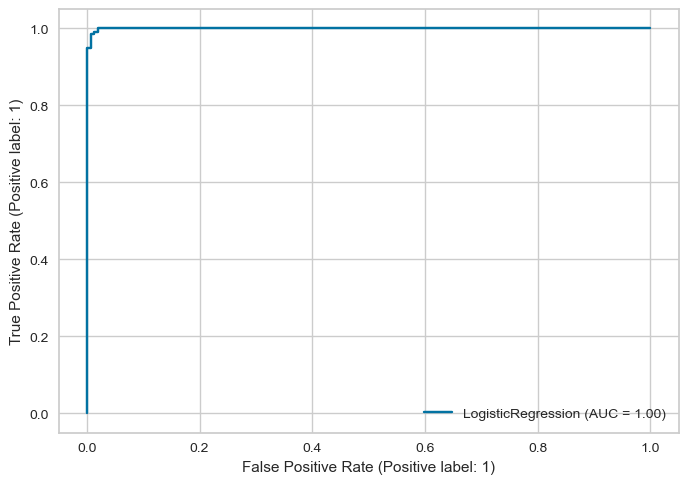

In [ ]:
from sklearn.metrics import plot_roc_curve

roc_auc_plot = plot_roc_curve(model_lr, X_test, y_test)
plt.show()

# La courbe donne le taux de vrais positifs en fonction du taux de faux positifs.

### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV


X = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]
Y = df2['is_genuine']

params = {'C' :[0,1,1,10], 'solver' :['liblinear','lbfgs']}

model = LogisticRegression()

gs = GridSearchCV(model, params, cv=5)
gs.fit(X, Y)

model = gs.best_estimator_

X_test = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]

y_test = df2['is_genuine']

score_model = model.score(X_test, y_test)
score_gs = gs.score(X_test, y_test)
best_params = gs.best_params_

result = pd.DataFrame({'LogisticRegression Model Score': [score_model], 'GridSearchCV Score': [score_gs],
                       'Best Parameters': [best_params]})
result

,LogisticRegression Model Score,GridSearchCV Score,Best Parameters
0,0.991333,0.991333,"{'C': 10, 'solver': 'liblinear'}"


### K-Nearest Neighbors algorithm

* K-Nearest Neighbors (KNN) est un algorithme d'apprentissage supervisé pour la classification et la régression. Il prédit l'étiquette d'une nouvelle instance en se basant sur les K instances d'entraînement les plus proches dans l'espace des caractéristiques.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Séparation X (features) et y (is_genuine)

X = df2[['diagonal','height_left', 'height_right', 'margin_up','margin_low','length']].copy()
y = df2.is_genuine

X_train, X_test, y_train, y_test  = train_test_split(X, y, stratify = y, test_size=0.3,random_state=41)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1050, 6) (450, 6) (1050,) (450,)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

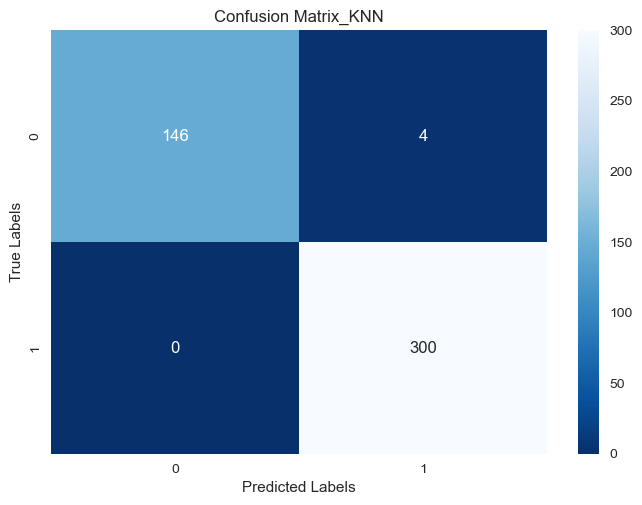

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap="Blues_r", fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.savefig('Confusion Matrix_KNN.png')
plt.title('Confusion Matrix_KNN');

In [ ]:
from sklearn import metrics

# Calculer le score R2

r2_score = metrics.r2_score(y_test, y_pred)
print('R2:', round(r2_score, 3))

R2: 0.96


In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.973     0.986       150
           1      0.987     1.000     0.993       300

    accuracy                          0.991       450
   macro avg      0.993     0.987     0.990       450
weighted avg      0.991     0.991     0.991       450



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Vrais positifs :",
      tp, "\nVrais négatifs :",tn, "\nFaux positifs : ",fp, "\nFaux négatifs : ",fn,)

print("\nDonc, avec KNN, nous avons",fn,"vrai billet détectés comme un faux billet et",
      fp,"faux billets détectés comme un vrai billet.")

Vrais positifs : 300 
Vrais négatifs : 146 
Faux positifs :  4 
Faux négatifs :  0

Donc, avec KNN, nous avons 0 vrai billet détectés comme un faux billet et 4 faux billets détectés comme un vrai billet.


In [ ]:
# La validation croisée

scores_knn = cross_val_score(knn, X, y, cv=5, scoring='accuracy')

score_mean = round(scores_knn.mean(), 3)

print("Score moyen : ", score_mean)

Score moyen :  0.991


In [ ]:
# Afficher la performance sur l'ensemble d'entraînement et l'ensemble de test

train_score = knn.score(X_train, y_train)
print("Performance sur l'ensemble d'entraînement :", round(train_score, 3))

test_score = knn.score(X_test, y_test)
print("Performance sur l'ensemble de test :", round(test_score, 3))

Performance sur l'ensemble d'entraînement : 0.991
Performance sur l'ensemble de test : 0.991


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

X = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]
Y = df2['is_genuine']

params = {'n_neighbors': range(3, 10)}

model = KNeighborsClassifier()

gs = GridSearchCV(model, params, cv=5)
gs.fit(X, Y)

model = gs.best_estimator_

X_test = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]

y_test = df2['is_genuine']

score_model = model.score(X_train, y_train)
best_params = gs.best_params_

result = pd.DataFrame({'Knn Model Score': [score_model],
                       'Best Parameters': [best_params]})
result

,Knn Model Score,Best Parameters
0,0.991429,{'n_neighbors': 3}


### xgboost

* XGBoost (eXtreme Gradient Boosting) est un modèle de Machine Learning très populaire, réputé pour ses performances élevées et sa rapidité. XGBoost est largement utilisé pour résoudre des problèmes de classification, de régression et des problématiques courantes en entreprise, tout en utilisant une quantité minimale de ressources.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Séparation X (features) et y (is_genuine)
X = df2[['diagonal','height_left', 'height_right', 'margin_up', 'margin_low', 'length']].copy()
y = df2.is_genuine

# Diviser les données en ensembles d'entraînement et de test avec une proportion de 70% pour l'entraînement et 30% pour le test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=41)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

In [ ]:
predictions = model.predict(dtest, output_margin=True)

predicted_labels = [1 if margin > 0 else 0 for margin in predictions]

cm = confusion_matrix(y_test, predicted_labels)
tn, fp, fn, tp = cm.ravel()

print("Vrais positifs :", tp, "\nVrais négatifs :", tn, "\nFaux positifs : ", fp, "\nFaux négatifs : ", fn)
print("\nDonc, avec Xgboost, nous avons",fn,"vrai billet détectés comme un faux billet et",
      fp,"faux billets détectés comme un vrai billet.")

Vrais positifs : 300 
Vrais négatifs : 146 
Faux positifs :  4 
Faux négatifs :  0

Donc, avec Xgboost, nous avons 0 vrai billet détectés comme un faux billet et 4 faux billets détectés comme un vrai billet.


In [ ]:
print(classification_report(y_test, predicted_labels, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.973     0.986       150
           1      0.987     1.000     0.993       300

    accuracy                          0.991       450
   macro avg      0.993     0.987     0.990       450
weighted avg      0.991     0.991     0.991       450



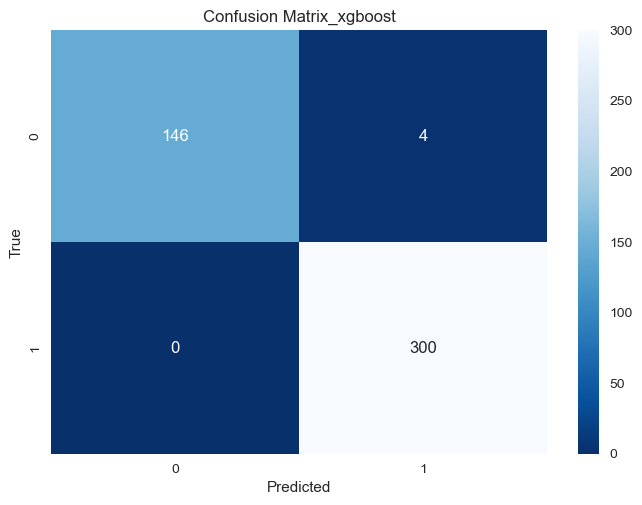

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

plt.title('Confusion Matrix_xgboost')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('Confusion Matrix_xgboost.png')
plt.show()

In [ ]:
r2_score = metrics.r2_score(y_test, predicted_labels)
print('R2:', round(r2_score, 3))

R2: 0.96


In [ ]:
predicted_labels = np.array(predicted_labels)

accuracy_train = accuracy_score(y_train, model.predict(dtrain, output_margin=True) > 0)
print("Précision sur l'ensemble d'entraînement: {:.2f}%".format(accuracy_train * 100))

accuracy_test = accuracy_score(y_test, predicted_labels)
print("Précision sur l'ensemble de test: {:.2f}%".format(accuracy_test * 100))

Précision sur l'ensemble d'entraînement: 99.81%
Précision sur l'ensemble de test: 99.11%


In [ ]:
cv_results = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=5, metrics='error', seed=42)

print("Score moyen : {:.3f}".format(np.mean(round(cv_results['test-error-mean'], 3))))

Score moyen : 0.012


### Bagging Classifier

* Le classifieur Bagging est une technique d'ensemble qui combine les prédictions de plusieurs modèles, entraînés sur des sous-ensembles aléatoires des données d'entraînement, pour améliorer les performances et réduire la variance du modèle. C'est utile pour éviter l'overfitting et obtenir de meilleures prédictions.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_model = DecisionTreeClassifier(random_state=42)
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=42)
bagging_model.fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.987     0.987     0.987       150
           1      0.993     0.993     0.993       300

    accuracy                          0.991       450
   macro avg      0.990     0.990     0.990       450
weighted avg      0.991     0.991     0.991       450



In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Vrais positifs :",
      tp, "\nVrais négatifs :",tn, "\nFaux positifs : ",fp, "\nFaux négatifs : ",fn,)

print("\nDonc, avec Bagging Classifier, nous avons",fn,"vrai billet détectés comme un faux billet et",
      fp,"faux billets détectés comme un vrai billet.")

Vrais positifs : 298 
Vrais négatifs : 148 
Faux positifs :  2 
Faux négatifs :  2

Donc, avec Bagging Classifier, nous avons 2 vrai billet détectés comme un faux billet et 2 faux billets détectés comme un vrai billet.


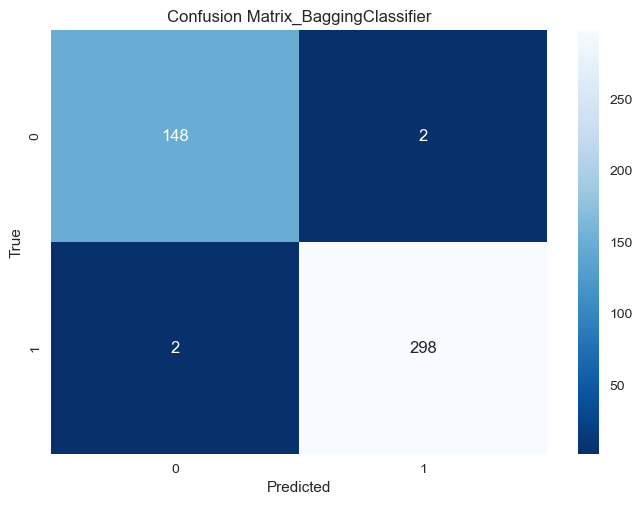

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

plt.title('Confusion Matrix_BaggingClassifier')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('Confusion Matrix_BaggingClassifier.png')
plt.show()

In [ ]:
r2_score = metrics.r2_score(y_test, y_pred)
print('R2:', round(r2_score, 4))

R2: 0.96


In [ ]:
# La validation croisée

scores_bagging_model = cross_val_score(bagging_model, X, y, cv=5, scoring='accuracy')

score_mean = round(scores_bagging_model.mean(), 3)

print("Score moyen : ", score_mean)

Score moyen :  0.987


# 4. Algorithme de Classification Non-Supervisée

# K means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, r2_score

k = 2

X = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']].copy()

kmeans = KMeans(n_clusters=k).fit(X)

centroids = kmeans.cluster_centers_

df2['cluster_km'] = kmeans.labels_

In [ ]:
df2.head()

,const,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_km
0,1.0,1,171.81,104.86,104.95,4.52,2.89,112.83,0
1,1.0,1,171.46,103.36,103.66,3.77,2.99,113.09,0
2,1.0,1,172.69,104.48,103.50,4.40,2.94,113.16,0
3,1.0,1,171.36,103.91,103.94,3.62,3.01,113.51,0
4,1.0,1,171.73,104.28,103.46,4.04,3.48,112.54,0


In [ ]:
df2['cluster_km'] = df2['cluster_km'].replace({0: 1, 1: 0})

In [ ]:
df2.head()

,const,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_km
0,1.0,1,171.81,104.86,104.95,4.52,2.89,112.83,1
1,1.0,1,171.46,103.36,103.66,3.77,2.99,113.09,1
2,1.0,1,172.69,104.48,103.50,4.40,2.94,113.16,1
3,1.0,1,171.36,103.91,103.94,3.62,3.01,113.51,1
4,1.0,1,171.73,104.28,103.46,4.04,3.48,112.54,1


In [ ]:
X = df2[['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']]
y = df2['cluster_km']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

kmeans_test = KMeans(n_clusters=k).fit(X_test)

y_pred = kmeans_test.predict(X_test)

r2 = r2_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Vrais positifs :",
      tp, "\nVrais négatifs :",tn, "\nFaux positifs : ",fp, "\nFaux négatifs : ",fn,)

print("\nDonc, avec K-means, nous avons",fn,"vrai billet détectés comme un faux billet et",
      fp,"faux billets détectés comme un vrai billet.")

Vrais positifs : 305 
Vrais négatifs : 143 
Faux positifs :  0 
Faux négatifs :  2

Donc, avec K-means, nous avons 2 vrai billet détectés comme un faux billet et 0 faux billets détectés comme un vrai billet.


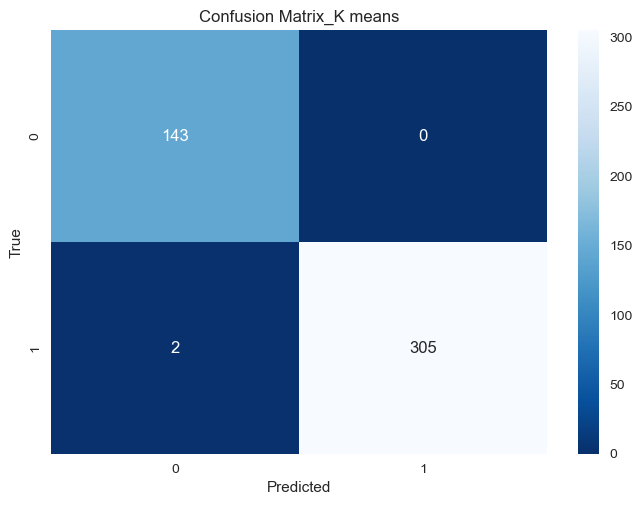

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

plt.title('Confusion Matrix_K means')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig('Confusion Matrix_K means.png')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.986     1.000     0.993       143
           1      1.000     0.993     0.997       307

    accuracy                          0.996       450
   macro avg      0.993     0.997     0.995       450
weighted avg      0.996     0.996     0.996       450



In [ ]:
r2_score = metrics.r2_score(y_test, y_pred)
print('R2:', round(r2_score, 3))

R2: 0.979


# 5. Résultats des différents modèles

In [ ]:
models = ['Logistic Regression', 'K-Nearest Neighbors', 'XGBoost', 'Bagging', 'K-Means']
R2 = [0.97, 0.96, 0.96, 0.96, 0.98]
accuracies = [0.993, 0.991, 0.991, 0.991, 0.996]
true_positives = [300, 300, 300, 298, 305]
true_negatives = [147, 146, 146, 148, 143]
false_positives = [3, 4, 4,  2, 0]
false_negatives = [0, 0, 0,  2, 2]

results_dict = {
    'Modèle': models,
    'R2': R2,
    'Précision': accuracies,
    'Vrais positifs': true_positives,
    'Vrais négatifs': true_negatives,
    'Faux positifs': false_positives,
    'Faux négatifs': false_negatives
}

results_df = pd.DataFrame(results_dict)
results_df.set_index('Modèle', inplace=True)
results_df

,R2,Précision,Vrais positifs,Vrais négatifs,Faux positifs,Faux négatifs
Modèle,,,,,,
Logistic Regression,0.97,0.993,300,147,3,0
K-Nearest Neighbors,0.96,0.991,300,146,4,0
XGBoost,0.96,0.991,300,146,4,0
Bagging,0.96,0.991,298,148,2,2
K-Means,0.98,0.996,305,143,0,2


* En conclusion, le modèle K-Means semble être le meilleur parmi tous les modèles évalués en termes de R2, précision, vrais positifs et vrais négatifs.